# Домашняя работа №3
## Выполнила Елизавета Клыкова, БКЛ181
### Импорт библиотек

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
!pip install transformers

In [3]:
import random
import time
import datetime

import numpy as np
import pandas as pd

from math import sqrt
from tqdm.auto import tqdm
from nltk.tokenize import word_tokenize, wordpunct_tokenize

import seaborn as sns
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset,\
    RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from keras.preprocessing.sequence import pad_sequences

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
seed = 117
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

### Скачиваем данные

In [6]:
# !wget https://raw.githubusercontent.com/semensorokin/DLforNLP_course_material/master/Homework2/answers_subsample.csv

1:80: E501 line too long (118 > 79 characters)


In [7]:
# если ругается на то, что нет wget
# !apt-get install wget

In [8]:
data = pd.read_csv('answers_subsample.csv')
data

,category,text
0,business,Могут ли в россельхозбанке дать в залог норков...
1,law,Может ли срочник перевестись на контракт после...
2,business,Продажа недвижимости по ипотеки ? ( арестованы...
3,business,"В чем смысл криптовалюты, какая от неё выгода ..."
4,law,часть 1 статья 158 похитил телефон
...,...,...
237774,relax,елку нарядили? =)
237775,law,"Имеется переработка при 75% ставки, отгулы не ..."
237776,food,Попробовала варить рис с половиной кубика для ...
237777,food,Почему рекоменд... Почему рекомендуют есть фру...


In [9]:
data.category.value_counts() * 100 / data.shape[0]

law         29.793211
relax       22.016242
business    19.309527
food        18.367055
love        10.513965
Name: category, dtype: float64

### Предобученные эмбеддинги
[Источник](https://fasttext.cc/docs/en/crawl-vectors.html)

Вы можете взять любые word2vec-подобные эмббединги. Если вы хотите использовать elmo, bert, etc., сначала попробуйте с word2vec-подобными эмббедингами, а потом можете перейти к более сложным моделям.

Ниже мы сначала скачиваем, а потом распаковываем эмбеддинги.

In [10]:
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz

In [11]:
# !gzip -d cc.ru.300.vec.gz

In [12]:
# потом можете добавить свою предобработку

def process_text(text):
    words = wordpunct_tokenize(text.lower())
    return words

In [13]:
word2freq = {}
lengths = []

for text in tqdm(data.text):

    words = process_text(text)
    lengths.append(len(words))

    for word in words:

        if word in word2freq:
            word2freq[word] += 1
        else:
            word2freq[word] = 1

  0%|          | 0/237779 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Распределение длин слов в текстах'}, xlabel='Длина предложения', ylabel='Доля'>

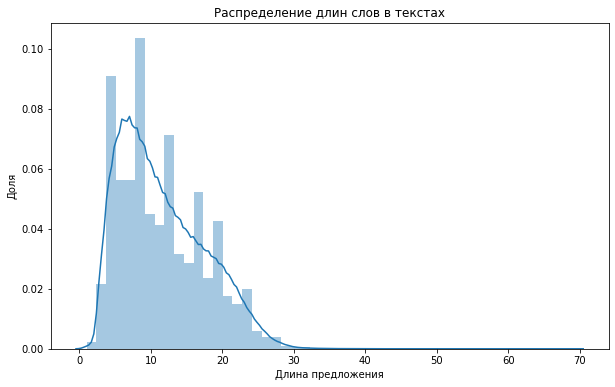

In [14]:
plt.figure(figsize=(10, 6))
plt.title('Распределение длин слов в текстах')
plt.xlabel('Длина предложения')
plt.ylabel('Доля')
sns.distplot(lengths)

In [15]:
upper_threshold = 32
lower_threshold = 3

correct_percent = len([sent_len for sent_len in lengths
                       if sent_len <= upper_threshold
                       and sent_len >= lower_threshold]) \
                  * 100 / len(lengths)

'{:.2f} % текстов содержат от {} до {} слов'.format(
    correct_percent, lower_threshold, upper_threshold)

'99.66 % текстов содержат от 3 до 32 слов'

In [16]:
len(word2freq)

152179

In [17]:
'Слов с частотностью <= 3: {}'.format(
    len([word for word in word2freq if word2freq[word] <= 3]))

'Слов с частотностью <= 3: 114332'

### Читаем файл с эмбеддингами
Это файл с 300 числами для 2 000 000 слов и он может не влезть в память, поэтому прочитаем только те слова, которые мы знаем.

In [18]:
word2index = {'PAD': 0}
vectors = []

word2vec_file = open('cc.ru.300.vec', encoding='utf-8')

n_words, embedding_dim = word2vec_file.readline().split()
n_words, embedding_dim = int(n_words), int(embedding_dim)

# Zero vector for PAD
vectors.append(np.zeros((1, embedding_dim)))

progress_bar = tqdm(desc='Read word2vec', total=n_words)

while True:

    line = word2vec_file.readline().strip()

    if not line:
        break

    current_parts = line.split()

    current_word = ' '.join(current_parts[:-embedding_dim])

    if current_word in word2freq:

        word2index[current_word] = len(word2index)

        current_vectors = current_parts[-embedding_dim:]
        current_vectors = np.array(list(map(float, current_vectors)))
        current_vectors = np.expand_dims(current_vectors, 0)

        vectors.append(current_vectors)

    progress_bar.update(1)

progress_bar.close()

word2vec_file.close()

vectors = np.concatenate(vectors)

Read word2vec:   0%|          | 0/2000000 [00:00<?, ?it/s]

In [19]:
len(word2index)

117619

In [20]:
unk_words = [word for word in word2freq if word not in word2index]
unk_counts = [word2freq[word] for word in unk_words]
n_unk = sum(unk_counts) * 100 / sum(list(word2freq.values()))

sub_sample_unk_words = {word: word2freq[word] for word in unk_words}
sorted_unk_words = list(sorted(sub_sample_unk_words,
                               key=lambda x: sub_sample_unk_words[x],
                               reverse=True))

print('Мы не знаем {:.2f} % слов в датасете'.format(n_unk))
print('Количество неизвестных слов {} из {}, то есть {:.2f} % \
уникальных слов в словаре'.format(len(unk_words), len(word2freq),
                                  len(unk_words) * 100 / len(word2freq)))
print('В среднем каждое встречается {:.2f} раз'.format(np.mean(unk_counts)))
print()
print('Топ 5 невошедших слов:')

for i in range(5):
    print(sorted_unk_words[i],
          'с количеством вхождениий -',
          word2freq[sorted_unk_words[i]])

Мы не знаем 2.50 % слов в датасете
Количество неизвестных слов 34561 из 152179, то есть 22.71 % уникальных слов в словаре
В среднем каждое встречается 1.98 раз

Топ 5 невошедших слов:
??? с количеством вхождениий - 3641
?? с количеством вхождениий - 2448
!!! с количеством вхождениий - 2214
?) с количеством вхождениий - 2069
"? с количеством вхождениий - 1429


### Потеря 2.5 % слов в датасете
Эта ситуация не то, чтобы сильно плохая, в учебных целях нормально, к тому же в среднем они редко встречаются. Вы можете поиграть с предобработкой.

- 128 - размер батча
- 64 - количество слов
- 1024 - эмбеддинг слова

In [21]:
x = torch.rand(128, 64, 1024)

In [22]:
lstm = torch.nn.LSTM(1024, 512, batch_first=True)

In [23]:
%%timeit

pred = lstm(x)

```286 ms ± 18.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)```

(в финальном варианте не запускаю, потому что timeit отрубает мне принты в юпитере))

### А что GPU?

In [24]:
print('Доступна ли видеокарта:', torch.cuda.is_available())
print('Если недоступна, поменяйте runtime, если в колабе')

Доступна ли видеокарта: True
Если недоступна, поменяйте runtime, если в колабе


In [25]:
device = torch.device('cuda') if torch.cuda.is_available()\
    else torch.device('cpu')

In [26]:
# перенесли x на gpu
x_gpu = x.to(device)

In [27]:
# зададим lstm на gpu
lstm_gpu = torch.nn.LSTM(1024, 512, batch_first=True)
lstm_gpu = lstm_gpu.to(device)

In [28]:
%%timeit

pred = lstm_gpu(x_gpu)

```1.02 ms ± 272 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)```

In [29]:
# если у нас модель на гпу, а то, что мы туда подаем нет, то работать не будет
# справедлива и обратная ситуация

# выскочит ошибка
# посмотрите на нее, возможно, вы еще встретитесь
# pred = lstm_gpu(x)

### Важные и не очень интуитивные моменты про LSTM и CNN в торче

По умолчанию LSTM принимает данные с такой размерностью:
```python
(seq_len, batch, input_size)
```
Сделано это с целью оптимизации на более низком уровне.  
Мы оперируем такими объектами:
```python
(batch, seq_len, input_size)
```
Чтобы LSTM у нас заработала правильно, мы можем либо передать параметр ```batch_first=True``` во время инициализации слоя,
либо транспонировать (поменять) первую и вторую размерность у нашего x перед подачей в слой.

[Подробнее про LSTM](https://pytorch.org/docs/stable/nn.html#lstm)

- 128 - размер батча
- 64 - количество слов
- 1024 - эмбеддинг слова

In [30]:
# первый способ
lstm = torch.nn.LSTM(1024, 512, batch_first=True)

pred, mem = lstm(x)

In [31]:
pred.shape

torch.Size([128, 64, 512])

In [32]:
lstm = torch.nn.LSTM(1024, 512)

# меняем размерность batch и seq_len местами
x_transposed = x.transpose(0, 1)
pred_transposed, mem = lstm(x_transposed)

In [33]:
# у нас все еще осталась размерность (seq_len, batch, input_size)
pred_transposed.shape

torch.Size([64, 128, 512])

In [34]:
# просто транспонируем еще раз
pred = pred_transposed.transpose(0, 1)
pred.shape

torch.Size([128, 64, 512])

### Conv1d & MaxPool1d
Примерно такая же ситуация происходит со сверточными слоями и пулингами.  
1d реализация как раз для текстов, в ней матрица-фильтр ходит только по одной размерности.

[Подробнее про CNN](https://pytorch.org/docs/stable/nn.html#conv1d)

[Подробнее про пулинг](https://pytorch.org/docs/stable/nn.html#maxpool1d)

Ожидается такая размерность:
```python
(batch, input_size, seq_len)
```
Мы все еще хоти подавать такую размерность:
```python
(batch, seq_len, input_size)
```
В случае со свертками и пулингами у нас есть вариант только транспонировать x перед подачей и транспонировать полученный результат. Обратите внимание, что транспонируем мы первую и вторую размерность (индексация с нуля).

In [35]:
x.shape

torch.Size([128, 64, 1024])

- 128 - размер батча
- 64 - количество слов
- 1024 - эмбеддинг слова

In [36]:
# in_channels - размер входных эмбеддингов
# out_channels - количество/какой размер эмбеддингов мы хотим получить
# kernel_size - размер окна/н-граммы
cnn = torch.nn.Conv1d(in_channels=1024, out_channels=512, kernel_size=3)

In [37]:
# выпадет ошибка, посмотрите какая
# pred = cnn(x)

In [38]:
x_transposed = x.transpose(1, 2)
x_transposed.shape
# перевели в (batch, input_size, seq_len)

torch.Size([128, 1024, 64])

In [39]:
pred_transposed = cnn(x_transposed)
pred_transposed.shape
# осталась разрмерность (batch, output_size, seq_len)

torch.Size([128, 512, 62])

In [40]:
# переведем обратно в (batch, seq_len, input_size)
pred = pred_transposed.transpose(1, 2)
pred.shape

torch.Size([128, 62, 512])

### Подготовим данные в DataLoader

In [41]:
'UNK' in word2index

False

In [42]:
data.head()

,category,text
0,business,Могут ли в россельхозбанке дать в залог норков...
1,law,Может ли срочник перевестись на контракт после...
2,business,Продажа недвижимости по ипотеки ? ( арестованы...
3,business,"В чем смысл криптовалюты, какая от неё выгода ..."
4,law,часть 1 статья 158 похитил телефон


### Замапим категории в индексы

In [43]:
cat_mapper = {cat: n for n, cat in enumerate(data.category.unique())}

In [44]:
cat_mapper

{'business': 0, 'law': 1, 'love': 2, 'relax': 3, 'food': 4}

In [45]:
data.category = data.category.map(cat_mapper)

## Читалка данных

### Что происходит ниже
1. Мы задаем x_data, y_data (таргеты), word2index (маппер из слова в индекс слова), sequence_length (максимальная длина последовательности; если больше, ограничить ею), pad_token (токен паддинга и задаем его индекс pad_index).


2. Загружаем данные:
    1. Проходимся по датасету
    2. Предобрабатываем каждый текст в датасете
    3. Индексируем его
    4. Паддим до нужной длины


3. Когда нам нужно достать пример из датасета, мы берем индексированный ```x``` и соответствующий этому индексу ```y```, наш ```x``` также паддим (или ограничиваем длину) и переводим в ```torch.Tensor(x).long()```. Для ```y``` этого делать не потребуется, в dataloader'е таргеты преобразуются в тензор сами.

In [46]:
class WordData(Dataset):

    def __init__(self, x_data, y_data, word2index,
                 sequence_length=32, pad_token='PAD',
                 verbose=True):

        super().__init__()

        self.x_data = []
        self.y_data = y_data

        self.word2index = word2index
        self.sequence_length = sequence_length

        self.pad_token = pad_token
        self.pad_index = self.word2index[self.pad_token]

        self.load(x_data, verbose=verbose)

    @staticmethod
    def process_text(text):

        # Место для вашей предобработки

        words = wordpunct_tokenize(text.lower())
        # words = re.findall('[a-яА-ЯеЁ]+', text.lower())
        return words

    def load(self, data, verbose=True):

        data_iterator = tqdm(data, desc='Loading data', disable=not verbose)

        for text in data_iterator:

            words = self.process_text(text)

            indexed_words = self.indexing(words)

            self.x_data.append(indexed_words)

    def indexing(self, tokenized_text):

        # здесь не используем токен UNK, потому что мы его специально не учили
        # становится непонятно какой же эмбеддинг присвоить неизвестному слову,
        # поэтому просто выбрасываем наши неизветсные слова

        return [self.word2index[word] for word in tokenized_text
                if word in self.word2index]

    def padding(self, sequence):

        # ограничить длину self.sequence_length
        # если длина меньше максимальной - западить
        if len(sequence) < self.sequence_length:
            add_pad = self.sequence_length - len(sequence)
            return sequence+[self.pad_index] * add_pad
        else:
            return sequence[:self.sequence_length]

    def __len__(self):

        return len(self.x_data)

    def __getitem__(self, idx):

        x = self.x_data[idx]
        x = self.padding(x)
        x = torch.Tensor(x).long()
        y = self.y_data[idx]

        return x, y

In [47]:
x_train, x_validation, y_train, y_validation = \
    train_test_split(data.text, data.category, test_size=0.1,
                     random_state=seed)

train_dataset = WordData(list(x_train), list(y_train), word2index)
train_loader = DataLoader(train_dataset, batch_size=64)

validation_dataset = WordData(list(x_validation), list(y_validation),
                              word2index)
validation_loader = DataLoader(validation_dataset, batch_size=64)

Loading data:   0%|          | 0/214001 [00:00<?, ?it/s]

Loading data:   0%|          | 0/23778 [00:00<?, ?it/s]

In [48]:
for x, y in train_loader:
    break

In [49]:
x

tensor([[   24,  1539,  2377,  ...,     0,     0,     0],
        [10778,  1067,  2454,  ...,     0,     0,     0],
        [  789,   451,   197,  ...,     0,     0,     0],
        ...,
        [  593,   764,  5139,  ...,     0,     0,     0],
        [  593,   520, 26324,  ...,     0,     0,     0],
        [   24, 34368,   114,  ...,     0,     0,     0]])

In [50]:
y

tensor([3, 0, 3, 3, 2, 1, 4, 0, 1, 1, 4, 0, 4, 1, 1, 1, 3, 0, 1, 0, 4, 1, 0, 1,
        2, 4, 3, 4, 2, 4, 3, 0, 1, 2, 1, 1, 2, 4, 1, 3, 1, 0, 2, 1, 3, 2, 3, 2,
        2, 1, 1, 2, 4, 3, 3, 0, 1, 4, 3, 0, 1, 3, 3, 3])

### Обучить нейронку
![title](attention.jpg)

In [51]:
class model_with_att(torch.nn.Module):

    def __init__(self, vocab_size, matrix_w, n=5, emb_size=300,
                 lstm_size=256, lin_size_3=256, cnn_out_size=128,
                 inner_lin_size=256):
        """
        vocab_size = размер словаря
        matrix_w = матрица весов
        n = кол-во категорий
        emb_size = размер эмбеддинга
        """

        super().__init__()

        self.n = n
        self.emb_size = emb_size
        self.emb_layer = torch.nn.Embedding.from_pretrained(
            torch.Tensor(matrix_w))

        self.LSTM = torch.nn.LSTM(emb_size, lstm_size, num_layers=2,
                                  batch_first=True, dropout=0.1,
                                  bidirectional=True)

        self.q_proj = torch.nn.Linear(in_features=lstm_size*2,
                                      out_features=lin_size_3,
                                      bias=True)
        self.k_proj = torch.nn.Linear(in_features=lstm_size*2,
                                      out_features=lin_size_3,
                                      bias=True)
        self.v_proj = torch.nn.Linear(in_features=lstm_size*2,
                                      out_features=lin_size_3,
                                      bias=True)

        self.att_soft = torch.nn.Softmax(dim=2)

        self.cnn_3gr = torch.nn.Conv1d(lin_size_3, cnn_out_size,
                                       kernel_size=(3,), stride=(1,))
        self.cnn_4gr = torch.nn.Conv1d(lin_size_3, cnn_out_size,
                                       kernel_size=(4,), stride=(1,))
        self.cnn_5gr = torch.nn.Conv1d(lin_size_3, cnn_out_size,
                                       kernel_size=(5,), stride=(1,))

        self.linear_1 = torch.nn.Linear(in_features=cnn_out_size*3,
                                        out_features=inner_lin_size,
                                        bias=True)
        self.relu = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(inner_lin_size, out_features=n)

    def forward(self, x):

        # применяем эмбеддинги
        x_emb = self.emb_layer(x)
        # транспонируем тензор для лстм, как было описано выше
        x_emb = x_emb.transpose(0, 1)
        # применим лстм
        x, _ = self.LSTM(x_emb)
        # транспонируем обратно
        x = x.transpose(0, 1)

        # применим линейные преобразования для селф-эттеншена
        x_q = self.q_proj(x)
        x_k = self.k_proj(x)
        x_v = self.v_proj(x)
        # транспонируем одну из матриц
        X_k_T = x_k.transpose(2, 1)

        # перемножаем тензоры, делим на корень из emb_size
        # на картинке неправильный порядок тензоров
        att_scores = torch.bmm(x_q, X_k_T) / sqrt(self.emb_size)
        # накидываем софтмакс
        att_dist = self.att_soft(att_scores)
        attention_vectors = torch.bmm(att_dist, x_v)

        # транспонируем для конволюционных фильтров
        x_att = attention_vectors.transpose(2, 1)

        # применяем свертки
        x_cnn3 = self.cnn_3gr(x_att)
        x_cnn4 = self.cnn_4gr(x_att)
        x_cnn5 = self.cnn_5gr(x_att)

        # max pooling
        frst, _ = x_cnn3.max(dim=-1,)
        sc, _ = x_cnn4.max(dim=-1,)
        thr, _ = x_cnn5.max(dim=-1,)

        # объединяем результаты
        x_cat = torch.cat((frst, sc, thr), dim=-1)

        # полносвязные слои с ReLU для классификации
        x = self.linear_1(x_cat)
        x = self.relu(x)
        x = self.linear_2(x)

        return x

In [52]:
n_classes = data.category.unique().shape[0]

In [53]:
model = model_with_att(len(word2index), vectors, n_classes)

In [54]:
model

model_with_att(
  (emb_layer): Embedding(117619, 300)
  (LSTM): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (q_proj): Linear(in_features=512, out_features=256, bias=True)
  (k_proj): Linear(in_features=512, out_features=256, bias=True)
  (v_proj): Linear(in_features=512, out_features=256, bias=True)
  (att_soft): Softmax(dim=2)
  (cnn_3gr): Conv1d(256, 128, kernel_size=(3,), stride=(1,))
  (cnn_4gr): Conv1d(256, 128, kernel_size=(4,), stride=(1,))
  (cnn_5gr): Conv1d(256, 128, kernel_size=(5,), stride=(1,))
  (linear_1): Linear(in_features=384, out_features=256, bias=True)
  (relu): ReLU()
  (linear_2): Linear(in_features=256, out_features=5, bias=True)
)

In [55]:
with torch.no_grad():
    pred = model(x)

In [56]:
pred.shape

torch.Size([64, 5])

In [57]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

model = model.to(device)
criterion = criterion.to(device)

In [58]:
def train(model, criterion, optimizer, train_loader,
          validation_loader, device, epochs=10):

    losses = []
    best_test_loss = 10.
    test_f1 = []

    for n_epoch in range(epochs):

        train_losses = []
        test_losses = []
        test_targets = []
        test_pred_class = []

        progress_bar = tqdm(total=len(train_loader.dataset),
                            desc='Epoch {}'.format(n_epoch + 1))

        model.train()

        for x, y in train_loader:

            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            losses.append(loss.item())

            progress_bar.set_postfix(train_loss=np.mean(losses[-500:]))
            progress_bar.update(x.shape[0])

        progress_bar.close()

        model.eval()

        for x, y in validation_loader:

            x = x.to(device)

            with torch.no_grad():

                pred = model(x)
                pred = pred.cpu()

                test_targets.append(y.numpy())
                test_pred_class.append(np.argmax(pred, axis=1))

                # перенос на GPU из-за весов в функции ошибки, см. ниже
                loss = criterion(pred.to(device), y.to(device))
                test_losses.append(loss.item())

        mean_test_loss = np.mean(test_losses)

        test_targets = np.concatenate(test_targets).squeeze()
        test_pred_class = np.concatenate(test_pred_class).squeeze()

        f1 = f1_score(test_targets, test_pred_class, average='micro')
        test_f1.append(f1)

        print()
        print('Losses: train - {:.3f}, test - {:.3f}'.format(
            np.mean(train_losses), mean_test_loss))

        print('F1 test - {:.3f}'.format(f1))

        # Early stopping:
        if mean_test_loss < best_test_loss:
            best_test_loss = mean_test_loss
        else:
            print('Early stopping')
            break

    return losses, test_f1, best_test_loss

In [59]:
losses, test_f1, best_test_loss = train(model, criterion,
                                        optimizer, train_loader,
                                        validation_loader, device)

Epoch 1:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.612, test - 0.490
F1 test - 0.821


Epoch 2:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.477, test - 0.472
F1 test - 0.830


Epoch 3:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.453, test - 0.469
F1 test - 0.833


Epoch 4:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.434, test - 0.464
F1 test - 0.837


Epoch 5:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.415, test - 0.478
F1 test - 0.833
Early stopping


**Было:**  
```Losses: train - 0.402, test - 0.447```  
```F1 test - 0.841```  
```Early stopping``` после 4 эпохи

**Стало:**  
```Losses: train - 0.434, test - 0.464```  
```F1 test - 0.837``` (на 4 эпохе)  
```Early stopping``` после 5 эпохи

Если вы запускаете много раз колаб окна и ткдм начинает беситься, можно запустить окно ниже, ткдм обновится и все снова станет хорошо

In [ ]:
# for instance in list(tqdm._instances):
#     tqdm._decr_instances(instance)

In [60]:
def plot_training(losses):
    plt.figure(figsize=(10, 8))
    plt.title('Training Process')
    plt.xlabel('Iterations')
    plt.ylabel('Cross Entropy Loss')
    plt.grid()
    plt.plot(losses)

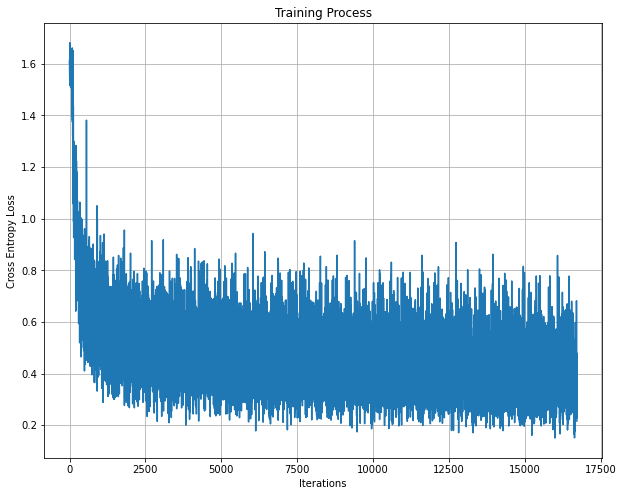

In [61]:
plot_training(losses)

## Оценка
1. ✔ Добрались сюда - очень хорошо - получилась такая же точность или около того - 7 баллов.
2. Поставили эксперименты и повысили точность относительно своей и не ниже F1 test - 0.841 - 8 баллов.
3. Запустили бертовую тетрадку и разобрались. Получился сравнимый результат - 10 баллов 

Переходим к экспериментам. Начнем с дропаутов.

In [62]:
class model_with_dropout(torch.nn.Module):

    def __init__(self, vocab_size, matrix_w, n=5, emb_size=300,
                 lstm_size=256, lin_size_3=256, cnn_out_size=128,
                 inner_lin_size=256, dropout_rate=0.5):
        """
        vocab_size = размер словаря
        matrix_w = матрица весов
        n = кол-во категорий
        emb_size = размер эмбеддинга
        """

        super().__init__()

        self.n = n
        self.emb_size = emb_size
        self.emb_layer = torch.nn.Embedding.from_pretrained(
            torch.Tensor(matrix_w))

        self.LSTM = torch.nn.LSTM(emb_size, lstm_size, num_layers=2,
                                  batch_first=True, dropout=0.1,
                                  bidirectional=True)

        self.q_proj = torch.nn.Linear(in_features=lstm_size*2,
                                      out_features=lin_size_3,
                                      bias=True)
        self.k_proj = torch.nn.Linear(in_features=lstm_size*2,
                                      out_features=lin_size_3,
                                      bias=True)
        self.v_proj = torch.nn.Linear(in_features=lstm_size*2,
                                      out_features=lin_size_3,
                                      bias=True)

        self.att_soft = torch.nn.Softmax(dim=2)

        self.cnn_3gr = torch.nn.Conv1d(lin_size_3, cnn_out_size,
                                       kernel_size=(3,), stride=(1,))
        self.cnn_4gr = torch.nn.Conv1d(lin_size_3, cnn_out_size,
                                       kernel_size=(4,), stride=(1,))
        self.cnn_5gr = torch.nn.Conv1d(lin_size_3, cnn_out_size,
                                       kernel_size=(5,), stride=(1,))

        self.linear_1 = torch.nn.Linear(in_features=cnn_out_size*3,
                                        out_features=inner_lin_size,
                                        bias=True)
        self.relu = torch.nn.ReLU()
        # новая штука
        self.dropout = torch.nn.Dropout(p=dropout_rate)
        self.linear_2 = torch.nn.Linear(inner_lin_size, out_features=n)

    def forward(self, x):

        # применяем эмбеддинги
        x_emb = self.emb_layer(x)
        # транспонируем тензор для лстм, как было описано выше
        x_emb = x_emb.transpose(0, 1)
        # применим лстм
        x, _ = self.LSTM(x_emb)
        # транспонируем обратно
        x = x.transpose(0, 1)

        # применим линейные преобразования для селф-эттеншена
        x_q = self.q_proj(x)
        x_k = self.k_proj(x)
        x_v = self.v_proj(x)
        # транспонируем одну из матриц
        X_k_T = x_k.transpose(2, 1)

        # перемножаем тензоры, делим на корень из emb_size
        # на картинке неправильный порядок тензоров
        att_scores = torch.bmm(x_q, X_k_T) / sqrt(self.emb_size)
        # накидываем софтмакс
        att_dist = self.att_soft(att_scores)
        attention_vectors = torch.bmm(att_dist, x_v)

        # транспонируем для конволюционных фильтров
        x_att = attention_vectors.transpose(2, 1)

        # применяем свертки
        x_cnn3 = self.cnn_3gr(x_att)
        x_cnn4 = self.cnn_4gr(x_att)
        x_cnn5 = self.cnn_5gr(x_att)

        # max pooling
        frst, _ = x_cnn3.max(dim=-1,)
        sc, _ = x_cnn4.max(dim=-1,)
        thr, _ = x_cnn5.max(dim=-1,)

        # объединяем результаты
        x_cat = torch.cat((frst, sc, thr), dim=-1)

        # новая штука: добавляем дропаут
        x = self.dropout(x_cat)

        # полносвязные слои с ReLU для классификации
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.linear_2(x)

        return x

In [63]:
model = model_with_dropout(len(word2index), vectors, n_classes)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

model = model.to(device)
criterion = criterion.to(device)

In [64]:
losses, test_f1, best_test_loss = train(model, criterion,
                                        optimizer, train_loader,
                                        validation_loader, device)

Epoch 1:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.629, test - 0.495
F1 test - 0.820


Epoch 2:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.480, test - 0.473
F1 test - 0.829


Epoch 3:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.458, test - 0.472
F1 test - 0.831


Epoch 4:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.440, test - 0.463
F1 test - 0.837


Epoch 5:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.422, test - 0.468
F1 test - 0.836
Early stopping


**Было:**  
```Losses: train - 0.434, test - 0.464```  
```F1 test - 0.837``` (на 4 эпохе)  
```Early stopping``` после 5 эпохи

**Стало:**  
```Losses: train - 0.440, test - 0.463```  
```F1 test - 0.837``` (на 4 эпохе)  
```Early stopping``` после 5 эпохи

Качество не улучшилось, лосс почти идентичный :(

Посмотрим на распределение классов в датасете.

In [65]:
data.category.value_counts()

1    70842
3    52350
0    45914
4    43673
2    25000
Name: category, dtype: int64

<AxesSubplot:>

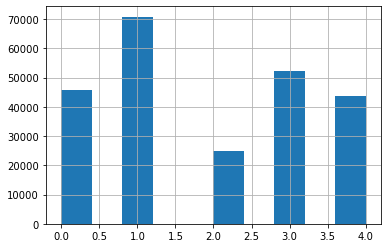

In [66]:
data.category.hist()

Ситуация не ужасная, но видно, что самый большой класс примерно в 2.5 раза больше самого маленького. Попробуем передать веса функции кросс-энтропии.

In [67]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weights

array([1.03417098, 0.6704187 , 1.90350011, 0.91011972, 1.09011767])

Попробуем обучить исходную модель, но с учетом полученных весов.

In [68]:
model = model_with_att(len(word2index), vectors, n_classes)

criterion = torch.nn.CrossEntropyLoss(
    weight=torch.FloatTensor(class_weights).to(device))
optimizer = torch.optim.Adam(params=model.parameters())

model = model.to(device)
criterion = criterion.to(device)

In [69]:
losses, test_f1, best_test_loss = train(model, criterion,
                                        optimizer, train_loader,
                                        validation_loader, device)

Epoch 1:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.614, test - 0.496
F1 test - 0.806


Epoch 2:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.479, test - 0.474
F1 test - 0.818


Epoch 3:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.453, test - 0.464
F1 test - 0.824


Epoch 4:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.432, test - 0.461
F1 test - 0.827


Epoch 5:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.412, test - 0.466
F1 test - 0.828
Early stopping


**Было:**  
```Losses: train - 0.434, test - 0.464```  
```F1 test - 0.837``` (на 4 эпохе)  
```Early stopping``` после 5 эпохи

**Стало:**  
```Losses: train - 0.412, test - 0.466```  
```F1 test - 0.828```  
```Early stopping``` после 5 эпохи

Не помогло :( Попробуем пошаманить с архитектурой модели. Вместо сверточного слоя 5-грамм сделаем слой биграмм.

In [70]:
class new_model(torch.nn.Module):

    def __init__(self, vocab_size, matrix_w, n=5, emb_size=300,
                 lstm_size=256, lin_size_3=256, cnn_out_size=128,
                 inner_lin_size=256):
        """
        vocab_size = размер словаря
        matrix_w = матрица весов
        n = кол-во категорий
        emb_size = размер эмбеддинга
        """

        super().__init__()

        self.n = n
        self.emb_size = emb_size
        self.emb_layer = torch.nn.Embedding.from_pretrained(
            torch.Tensor(matrix_w))

        self.LSTM = torch.nn.LSTM(emb_size, lstm_size, num_layers=2,
                                  batch_first=True, dropout=0.1,
                                  bidirectional=True)

        self.q_proj = torch.nn.Linear(in_features=lstm_size*2,
                                      out_features=lin_size_3,
                                      bias=True)
        self.k_proj = torch.nn.Linear(in_features=lstm_size*2,
                                      out_features=lin_size_3,
                                      bias=True)
        self.v_proj = torch.nn.Linear(in_features=lstm_size*2,
                                      out_features=lin_size_3,
                                      bias=True)

        self.att_soft = torch.nn.Softmax(dim=2)

        self.cnn_2gr = torch.nn.Conv1d(lin_size_3, cnn_out_size,
                                       kernel_size=(2,), stride=(1,))
        self.cnn_3gr = torch.nn.Conv1d(lin_size_3, cnn_out_size,
                                       kernel_size=(3,), stride=(1,))
        self.cnn_4gr = torch.nn.Conv1d(lin_size_3, cnn_out_size,
                                       kernel_size=(4,), stride=(1,))

        self.linear_1 = torch.nn.Linear(in_features=cnn_out_size*3,
                                        out_features=inner_lin_size,
                                        bias=True)
        self.relu = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(inner_lin_size, out_features=n)

    def forward(self, x):

        # применяем эмбеддинги
        x_emb = self.emb_layer(x)
        # транспонируем тензор для лстм, как было описано выше
        x_emb = x_emb.transpose(0, 1)
        # применим лстм
        x, _ = self.LSTM(x_emb)
        # транспонируем обратно
        x = x.transpose(0, 1)

        # применим линейные преобразования для селф-эттеншена
        x_q = self.q_proj(x)
        x_k = self.k_proj(x)
        x_v = self.v_proj(x)
        # транспонируем одну из матриц
        X_k_T = x_k.transpose(2, 1)

        # перемножаем тензоры, делим на корень из emb_size
        # на картинке неправильный порядок тензоров
        att_scores = torch.bmm(x_q, X_k_T) / sqrt(self.emb_size)
        # накидываем софтмакс
        att_dist = self.att_soft(att_scores)
        attention_vectors = torch.bmm(att_dist, x_v)

        # транспонируем для конволюционных фильтров
        x_att = attention_vectors.transpose(2, 1)

        # применяем свертки
        x_cnn2 = self.cnn_2gr(x_att)
        x_cnn3 = self.cnn_3gr(x_att)
        x_cnn4 = self.cnn_4gr(x_att)

        # max pooling
        frst, _ = x_cnn2.max(dim=-1,)
        sc, _ = x_cnn3.max(dim=-1,)
        thr, _ = x_cnn4.max(dim=-1,)

        # объединяем результаты
        x_cat = torch.cat((frst, sc, thr), dim=-1)

        # полносвязные слои с ReLU для классификации
        x = self.linear_1(x_cat)
        x = self.relu(x)
        x = self.linear_2(x)

        return x

In [71]:
model = new_model(len(word2index), vectors, n_classes)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

model = model.to(device)
criterion = criterion.to(device)

In [72]:
losses, test_f1, best_test_loss = train(model, criterion,
                                        optimizer, train_loader,
                                        validation_loader, device)

Epoch 1:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.597, test - 0.490
F1 test - 0.825


Epoch 2:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.473, test - 0.473
F1 test - 0.830


Epoch 3:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.452, test - 0.462
F1 test - 0.834


Epoch 4:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.433, test - 0.463
F1 test - 0.836
Early stopping


Опять не помогло :( (Самое интересное, что я делала ровно то же самое с другим сидом, и был прирост качества 0.003)

**Было:**  
```Losses: train - 0.434, test - 0.464```  
```F1 test - 0.837``` (на 4 эпохе)  
```Early stopping``` после 5 эпохи

**Стало:**  
```Losses: train - 0.433, test - 0.463```  
```F1 test - 0.836```  
```Early stopping``` после 4 эпохи   

Попробуем еще что-то поменять, чтобы добить качество до 0.841 (но это вряд ли удастся, потому что у меня изначально не самый удачный сид и плохое качество). Уменьшим размерность LSTM.

In [74]:
model = model_with_att(len(word2index), vectors, n_classes,
                       lstm_size=128)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

model = model.to(device)
criterion = criterion.to(device)

In [75]:
losses, test_f1, best_test_loss = train(model, criterion,
                                        optimizer, train_loader,
                                        validation_loader, device)

Epoch 1:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.625, test - 0.489
F1 test - 0.824


Epoch 2:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.474, test - 0.470
F1 test - 0.831


Epoch 3:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.453, test - 0.462
F1 test - 0.835


Epoch 4:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.436, test - 0.464
F1 test - 0.836
Early stopping


Все еще не помогло :( (Это я тоже делала с другим сидом и был прирост качества)

**Было:**  
```Losses: train - 0.434, test - 0.464```  
```F1 test - 0.837``` (на 4 эпохе)  
```Early stopping``` после 5 эпохи

**Стало:**  
```Losses: train - 0.436, test - 0.464```  
```F1 test - 0.836```  
```Early stopping``` после 4 эпохи 

Попробуем еще поменять функцию активации на Parametriс ReLU (Leaky ReLU не будем пробовать, она вряд ли значительно повлияет).

In [76]:
class model_with_prelu(torch.nn.Module):

    def __init__(self, vocab_size, matrix_w, n=5, emb_size=300,
                 lstm_size=256, lin_size_3=256, cnn_out_size=128,
                 inner_lin_size=256):
        """
        vocab_size = размер словаря
        matrix_w = матрица весов
        n = кол-во категорий
        emb_size = размер эмбеддинга
        """

        super().__init__()

        self.n = n
        self.emb_size = emb_size
        self.emb_layer = torch.nn.Embedding.from_pretrained(
            torch.Tensor(matrix_w))

        self.LSTM = torch.nn.LSTM(emb_size, lstm_size, num_layers=2,
                                  batch_first=True, dropout=0.1,
                                  bidirectional=True)

        self.q_proj = torch.nn.Linear(in_features=lstm_size*2,
                                      out_features=lin_size_3,
                                      bias=True)
        self.k_proj = torch.nn.Linear(in_features=lstm_size*2,
                                      out_features=lin_size_3,
                                      bias=True)
        self.v_proj = torch.nn.Linear(in_features=lstm_size*2,
                                      out_features=lin_size_3,
                                      bias=True)

        self.att_soft = torch.nn.Softmax(dim=2)

        self.cnn_3gr = torch.nn.Conv1d(lin_size_3, cnn_out_size,
                                       kernel_size=(3,), stride=(1,))
        self.cnn_4gr = torch.nn.Conv1d(lin_size_3, cnn_out_size,
                                       kernel_size=(4,), stride=(1,))
        self.cnn_5gr = torch.nn.Conv1d(lin_size_3, cnn_out_size,
                                       kernel_size=(5,), stride=(1,))

        self.linear_1 = torch.nn.Linear(in_features=cnn_out_size*3,
                                        out_features=inner_lin_size,
                                        bias=True)
        self.relu = torch.nn.PReLU()
        self.linear_2 = torch.nn.Linear(inner_lin_size, out_features=n)

    def forward(self, x):

        # применяем эмбеддинги
        x_emb = self.emb_layer(x)
        # транспонируем тензор для лстм, как было описано выше
        x_emb = x_emb.transpose(0, 1)
        # применим лстм
        x, _ = self.LSTM(x_emb)
        # транспонируем обратно
        x = x.transpose(0, 1)

        # применим линейные преобразования для селф-эттеншена
        x_q = self.q_proj(x)
        x_k = self.k_proj(x)
        x_v = self.v_proj(x)
        # транспонируем одну из матриц
        X_k_T = x_k.transpose(2, 1)

        # перемножаем тензоры, делим на корень из emb_size
        # на картинке неправильный порядок тензоров
        att_scores = torch.bmm(x_q, X_k_T) / sqrt(self.emb_size)
        # накидываем софтмакс
        att_dist = self.att_soft(att_scores)
        attention_vectors = torch.bmm(att_dist, x_v)

        # транспонируем для конволюционных фильтров
        x_att = attention_vectors.transpose(2, 1)

        # применяем свертки
        x_cnn3 = self.cnn_3gr(x_att)
        x_cnn4 = self.cnn_4gr(x_att)
        x_cnn5 = self.cnn_5gr(x_att)

        # max pooling
        frst, _ = x_cnn3.max(dim=-1,)
        sc, _ = x_cnn4.max(dim=-1,)
        thr, _ = x_cnn5.max(dim=-1,)

        # объединяем результаты
        x_cat = torch.cat((frst, sc, thr), dim=-1)

        # полносвязные слои с ReLU для классификации
        x = self.linear_1(x_cat)
        x = self.relu(x)
        x = self.linear_2(x)

        return x

In [77]:
model = model_with_prelu(len(word2index), vectors, n_classes)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

model = model.to(device)
criterion = criterion.to(device)

In [78]:
losses, test_f1, best_test_loss = train(model, criterion,
                                        optimizer, train_loader,
                                        validation_loader, device)

Epoch 1:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.596, test - 0.491
F1 test - 0.824


Epoch 2:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.472, test - 0.473
F1 test - 0.830


Epoch 3:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.450, test - 0.465
F1 test - 0.833


Epoch 4:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.432, test - 0.465
F1 test - 0.836


Epoch 5:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.412, test - 0.473
F1 test - 0.834
Early stopping


**Было:**  
```Losses: train - 0.434, test - 0.464```  
```F1 test - 0.837``` (на 4 эпохе)  
```Early stopping``` после 5 эпохи

**Стало:**  
```Losses: train - 0.432, test - 0.465```  
```F1 test - 0.836``` (на 4 эпохе)  
```Early stopping``` после 4 эпохи 

\*дергающийся глаз\*

Попробуем добавить scheduler, после чего я сдаюсь))

In [79]:
from torch.optim.lr_scheduler import ExponentialLR

model = model_with_att(len(word2index), vectors, n_classes)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())
scheduler = ExponentialLR(optimizer, gamma=0.4)

model = model.to(device)
criterion = criterion.to(device)

In [80]:
def train_with_scheduler(model, criterion, optimizer,
                         train_loader, validation_loader,
                         scheduler, device, epochs=10):

    losses = []
    best_test_loss = 10.
    test_f1 = []

    for n_epoch in range(epochs):

        train_losses = []
        test_losses = []
        test_targets = []
        test_pred_class = []

        progress_bar = tqdm(total=len(train_loader.dataset),
                            desc='Epoch {}'.format(n_epoch + 1))

        model.train()

        for x, y in train_loader:

            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            losses.append(loss.item())

            progress_bar.set_postfix(train_loss=np.mean(losses[-500:]))
            progress_bar.update(x.shape[0])

        scheduler.step()
        progress_bar.close()

        model.eval()

        for x, y in validation_loader:

            x = x.to(device)

            with torch.no_grad():

                pred = model(x)
                pred = pred.cpu()

                test_targets.append(y.numpy())
                test_pred_class.append(np.argmax(pred, axis=1))

                # перенос на GPU из-за весов в функции ошибки, см. ниже
                loss = criterion(pred.to(device), y.to(device))
                test_losses.append(loss.item())

        mean_test_loss = np.mean(test_losses)

        test_targets = np.concatenate(test_targets).squeeze()
        test_pred_class = np.concatenate(test_pred_class).squeeze()

        f1 = f1_score(test_targets, test_pred_class, average='micro')
        test_f1.append(f1)

        print()
        print('Losses: train - {:.3f}, test - {:.3f}'.format(
            np.mean(train_losses), mean_test_loss))

        print('F1 test - {:.3f}'.format(f1))

        # Early stopping:
        if mean_test_loss < best_test_loss:
            best_test_loss = mean_test_loss
        else:
            print('Early stopping')
            break

    return losses, test_f1, best_test_loss

In [82]:
losses, test_f1, best_test_loss = train_with_scheduler(
    model, criterion, optimizer, train_loader,
    validation_loader, scheduler, device)

Epoch 1:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.602, test - 0.493
F1 test - 0.823


Epoch 2:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.457, test - 0.462
F1 test - 0.834


Epoch 3:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.436, test - 0.454
F1 test - 0.837


Epoch 4:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.425, test - 0.449
F1 test - 0.838


Epoch 5:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.420, test - 0.447
F1 test - 0.839


Epoch 6:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.418, test - 0.446
F1 test - 0.839


Epoch 7:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.417, test - 0.445
F1 test - 0.839


Epoch 8:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.416, test - 0.444
F1 test - 0.839


Epoch 9:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.416, test - 0.444
F1 test - 0.839


Epoch 10:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.416, test - 0.444
F1 test - 0.840


 Ура, победа!

**Было:**  
```Losses: train - 0.434, test - 0.464```  
```F1 test - 0.837``` (на 4 эпохе)  
```Early stopping``` после 5 эпохи

**Стало:**  
```Losses: train - 0.416, test - 0.444```  
```F1 test - 0.840```  
```10 эпох``` (можно было еще поучить, но вряд ли сильно улучшится, а домашку хочется сдать до дедлайна))

**Итоги по улучшениям:**
* попробовали добавлять **dropout** (p=0.5) -- стало хуже
* попробовали учитывать **веса классов** в CrossEntropyLoss -- стало хуже
* попробовали заменять **5-граммный слой на биграммный** -- не улучшилось (но улучшалось на 0.003 с другим сидом, тут не угадаешь)
* попробовали уменьшать **размерность LSTM** -- не улучшилось (тоже улучшалось на 0.003 с другим сидом)
* попробовали заменить ReLU на **PReLU** -- не улучшилось (очень близко к бейслайну, на самом деле ожидаемо)
* попробовали использовать **scheduler** -- **качество улучшилось до 0.840**

Если останется время (сомневаюсь), то попробую увеличить гамму и лернинг рейт.

В свое оправдание скажу, что, видимо, чем хуже исходное качество, тем легче улучшать. С прошлым сидом у меня качество бейслайна было 0.833, и до 0.837 я смогла его поднять даже без scheduler'а, а сейчас исходный f1 уже 0.837, и даже со scheduler я смогла улучшить всего на 0.003 :(

## BERT
Будет в другой тетрадке.